In [2]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import os
import random
import codecs
import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import pylab
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load data and pick a sample of 10%
data = pd.read_pickle("darklyrics/artist_data_normal.pkl")
#data = data.sample(frac=0.1)

/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/application.py:106: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="""Generate default config file."""
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/application.py:110: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="Specify a config file to load."
/home/nloyola/anaconda2/envs/metal/lib/python2.7/site-packages/jupyter_core/ap

In [3]:
# http://www.metalstorm.net/users/list.php?list_id=2413
# Top 150 metal bands
top_bands = [
    "black sabbath", "judas priest", "slipknot", "iron maiden", "metallica", "venom", "motorhead",
    "slayer", "celtic frost", "bathory", "helloween", "possessed", "death", "pantera", "godflesh", "morbid angel",
    "paradise lost", "at the gates", "mercyful fate", "accept", "melvins", "budgie", "queensryche", "kreator",
    "napalm death", "gorguts", "sepultura", "dream theater", "mayhem", "yngwie malmsteen", "manowar", "candlemass",
    "watchtower", "burzum", "emperor", "atheist", "repulsion", "pentagram", "trouble", "saint vitus", "entombed",
    "obituary", "neurosis", "ministry", "suffocation", "diamond head", "anthrax", "darkthrone", "megadeth",
    "autopsy", "savatage", "fates warning", "suicidal tendencies", "carcass", "deicide", "exodus", "amorphis",
    "fear factory", "immortal", "sodom", "my dying bride", "the gathering", "theatre of tragedy", "dark angel",
    "the 3rd and the mortal", "saxon", "thergothon", "earth", "opeth", "isis", "sleep", "blind guardian", "therion",
    "in flames", "d.r.i.", "meshuggah", "rhapsody of fire", "stratovarius", "manilla road", "destruction", u"sarcófago",
    "tiamat", "nightwish", "children of bodom", "enslaved", "dissection", "dark tranquillity", "master's hammer", 
    "master", "cannibal corpse", "nocturnus", "crimson glory", "anathema", "bethlehem", "cathedral", "ulver",
    "katatonia", "terrorizer", "w.a.s.p.", "raven", "anvil", "dio", "gamma ray", "ozzy osbourne", "skyclad", "cynic",
    "type o negative", "skepticism", "disembowelment", "danzig", "graveland", "rotting christ", "sentenced", 
    "immolation", "bolt thrower", "exhumed", "angel witch", "winter", "vulcano", "corrosion of conformity", 
    "king diamond", "machine head", "eyehategod", "crowbar", "carnivore", "exhorder", "unholy", "prong", 
    "testament", "overkill", "slaughter", "massacre", "voivod", "hammerfall", "dimmu borgir", "cradle of filth", 
    "satyricon", "in the woods...", "mastodon", "witchfinder general", "running wild", "metal church", 
    "marduk", "samael", "strapping young lad",  "symphony x", "nile", "summoning", "dillinger escape plan", 
    "converge"
]
data = data.to_frame()
data = data.reset_index()

In [9]:
# Review that artists in previous list are contained in dataset

not_found = []
for band in top_bands:
    filtered = data[data['artist'] == band]
    if len(filtered) == 0:
        not_found.append(band)
data = data[data['artist'].isin(top_bands)]
print len(data)
data

150


,artist,lyrics_string
153,accept,crash bars door stomping town crowd crush beyo...
378,amorphis,retired towering mountain laid circle stones t...
407,anathema,tonight im free free first time ive seen new l...
438,angel witch,time stops pass mind know im kind see things n...
485,anthrax,die screaming give want gonna get get either w...
501,anvil,yo ho ho yo ho ho give us bottle rum yo ho ho ...
683,at the gates,trail serpent models fear generation buried be...
693,atheist,second sun second sun like jupiter ones atoms ...
732,autopsy,saw woods sneaking like rat sick pleasure mind...
824,bathory,night divides day dark come everyone fear stri...


## TF-IDF Vectorization

In [4]:
begin = time()
total = time()
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', min_df=25, max_df=0.5)
x = vectorizer.fit_transform(data['lyrics_string'])
end = time()
print 'TFIDF vectorization performed in %f seconds' % (end - begin)
print 'Num samples: %d, num features: %d' % x.shape
features = vectorizer.get_feature_names()

TFIDF vectorization performed in 16.428058 seconds
Num samples: 7433, num features: 17144


## Clustering

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(x)

In [17]:
num_clusters = 30
km = KMeans(n_clusters=num_clusters)
begin = time()
km.fit(x)
end = time()
print 'K means computed in %f' % (end - begin)

K means computed in 150.456133


In [18]:
from sklearn.externals import joblib

joblib.dump(km, 'darklyrics/doc_cluster_big.pkl')
#km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [19]:
cluster_labels = {}
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    cluster_labels[i] = ""
    for ind in order_centroids[i, :30]: 
        cluster_labels[i] += '%s ' % features[ind].encode('utf-8', 'ignore')
    cluster_labels[i] = cluster_labels[i][:-1]

data['cluster'] = clusters
data['cluster_labels'] = data.apply(lambda x: cluster_labels[x['cluster']], axis=1)
data['cluster'].value_counts()

19    1166
7     1095
1      688
27     571
3      487
11     458
2      403
4      364
25     291
23     284
8      262
17     201
16     199
9      161
22     126
28     108
12      96
5       94
10      90
24      73
18      64
26      34
21      17
15      17
0       17
14      15
20      15
6       15
29      14
13       8
Name: cluster, dtype: int64

In [22]:
data.head()
data.to_pickle("darklyrics/clustered_lyrics.pkl")

In [21]:
print "Top terms per cluster:"
print ""

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print "Cluster %d words: " % i
    print ""
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print ' %s' % features[ind].encode('utf-8', 'ignore'),
    print ""
    print ""
    
    print "Cluster %d artists:" % i
    for artist_index, row in data[data['cluster'] == i].iterrows():
        print ('%s,' % row['artist']),
    print ""
    print ""

Top terms per cluster:

Cluster 0 words: 

 gimme  maybe  aint  hey  lying  gonna  shes  class  baby  rice  goddamn  youve  looking  bullets  half  speed  corrosion  thats  backstreet  shake  fooling  lotta  sis  rain  better  breathe  believin  smile  midnight  smoke 

Cluster 0 artists:
'68, beseech, big jesus, dopethrone, hellium, hermetica, hyubris, in extremo, karelian warcry, mägo de oz, red wine, sinergy, spinal tap, stratus, suicide note, weedeater, wolf eyes, 

Cluster 1 words: 

 shall  existence  self  control  reality  fucking  minds  humanity  future  evil  suffering  faith  final  eternal  chaos  hatred  destruction  disease  void  race  weak  endless  mankind  demise  creation  misery  feed  gods  force  suffer 

Cluster 1 artists:
(sic)monic, 7 horns 7 eyes, 7th nemesis, a night in texas, a red nightmare, abaddon incarnate, abidetherein, abiotic, abnormality, abstract rapture, abysmal dawn, abysmal torment, abysmalia, acrania, across the sun, act of defiance, ad hominem

## Multidimensional Scaling

In [23]:
from sklearn.manifold import MDS

MDS()
mds = MDS(dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(distance)
xs, ys = pos[:, 0], pos[:, 1]

In [24]:
cluster_tags = {}
cluster_colors = {}
r_color = lambda: random.randint(0,255)

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):    
    tags = ""
    for ind in order_centroids[i, :3]: #replace 6 with n words per cluster
        tags = tags + features[ind].encode('utf-8', 'ignore') + " "
    cluster_tags[i] = tags
    cluster_colors[i] = '#%02X%02X%02X' % (r_color(),r_color(),r_color())
    
cluster_tags

{0: 'gimme maybe aint ',
 1: 'shall existence self ',
 2: 'ancient moon gods ',
 3: 'fly rain wind ',
 4: 'gonna people fucking ',
 5: 'satan evil shall ',
 6: 'rome roman caesar ',
 7: 'youve change forget ',
 8: 'yeah gonna baby ',
 9: 'sword battle gods ',
 10: 'christ jesus lord ',
 11: 'youve change said ',
 12: 'meat gore rotting ',
 13: 'ov thine coz ',
 14: 'la los beer ',
 15: 'fuckin fuck fucking ',
 16: 'shall evil satan ',
 17: 'thy shall thou ',
 18: 'ja ei ni ',
 19: 'shall fucking evil ',
 20: 'ye thy thou ',
 21: 'forest trees revolt ',
 22: 'fuck fucking shit ',
 23: 'evil shall king ',
 24: 'fucking fuck cunt ',
 25: 'fucking fuck shit ',
 26: 'nie si ci ',
 27: 'shall wind stars ',
 28: 'metal steel heavy ',
 29: 'corpse tissue organs '}

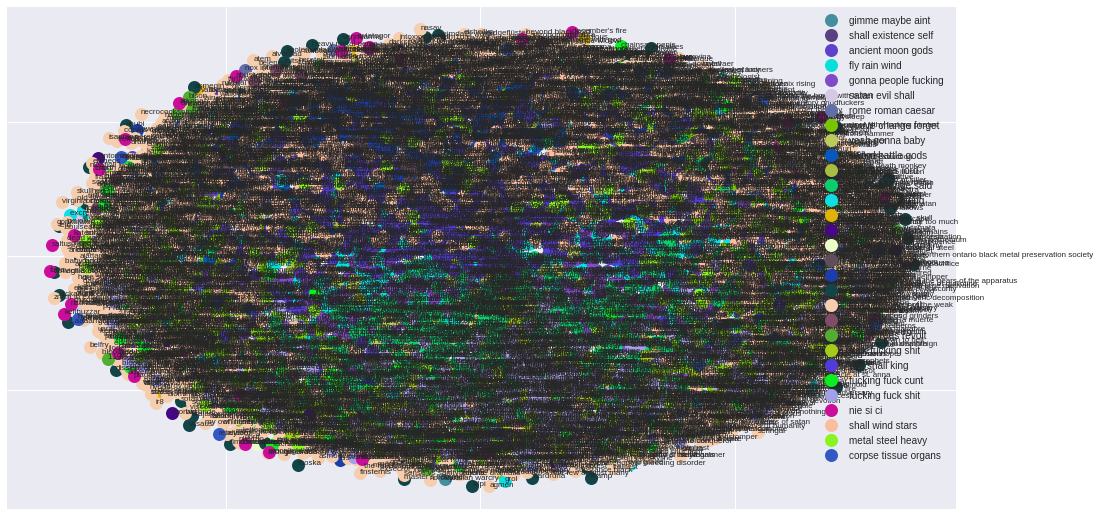

In [25]:
%matplotlib inline 

data['x'] = xs
data['y'] = ys
clustered = data.groupby('cluster')

fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

for name, group in clustered:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=13, 
            label=cluster_tags[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom='off', 
        top='off',  
        labelbottom='off')
    ax.tick_params(\
        axis= 'y', 
        which='both',
        left='off',
        top='off',
        labelleft='off')
    
legend = ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i, row in data.iterrows():
    ax.text(row['x'], row['y'], row['artist'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Interactive Plot

In [26]:
class TweakToolbar(mpld3.plugins.PluginBase):

    JAVASCRIPT = """
    mpld3.register_plugin("tweaktoolbar", TweakToolbar);
    TweakToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TweakToolbar.prototype.constructor = TweakToolbar;
    function TweakToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TweakToolbar.prototype.draw = function(){
      this.fig.toolbar.draw();
      this.fig.toolbar.buttonsobj.transition(750).attr("y", 0);
      this.fig.canvas
        .on("mouseenter", null)
        .on("mouseleave", null)
        .on("touchenter", null)
        .on("touchstart", null);

      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "tweaktoolbar"}

In [27]:
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

fig, ax = plt.subplots(figsize=(18,10))


for name, group in clustered:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_tags[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.artist]
    
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    
    zoom = mpld3.plugins.Zoom(button=False, enabled=True)
    mpld3.plugins.connect(fig, tooltip, zoom, TweakToolbar())    
    
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

legend = ax.legend(numpoints=1, loc="upper left", bbox_to_anchor=(0.01, 1), 
          fontsize='xx-small', labelspacing=2, borderpad=2, frameon=True) 

html = mpld3.fig_to_html(fig)
f = open("cluster_mds_big.html", "w")
f.write(html)
f.close()

mpld3.display()

In [28]:
total_end = time()
print 'Total computations done in %f' % (total_end - total)
data.to_pickle("darklyrics/clustered_lyrics.pkl")

Total computations done in 15915.060883
